In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
data = pd.read_csv('./hochgerner_2018.data.gz',sep='\t',index_col=0)
anno = pd.read_csv('./hochgerner_2018.anno',sep='\t',header=None)
anno = anno[1].values


In [ ]:
#install seaborn for plotting if you don't have it installed
#!pip install seaborn

In [2]:
#We will first normalize each cell by total count per cell.
percell_sum = data.sum(axis=0)
pergene_sum = data.sum(axis=1)

preprocessed_data = data / percell_sum.values[None, :] * np.median(percell_sum)
preprocessed_data = preprocessed_data.values

#transform the preprocessed_data array by `x := log (1+x)`
preprocessed_data = np.log(1 + preprocessed_data)

#standard scaling
preprocessed_data_mean = preprocessed_data.mean(axis=1)
preprocessed_data_std = preprocessed_data.std(axis=1)
preprocessed_data = (preprocessed_data - preprocessed_data_mean[:, None]) / \
                     preprocessed_data_std[:, None]



In [3]:
#preprocess by PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
pca.fit(preprocessed_data.T)
pca_data = pca.transform(preprocessed_data.T)

Text(0, 0.5, 'PC2')

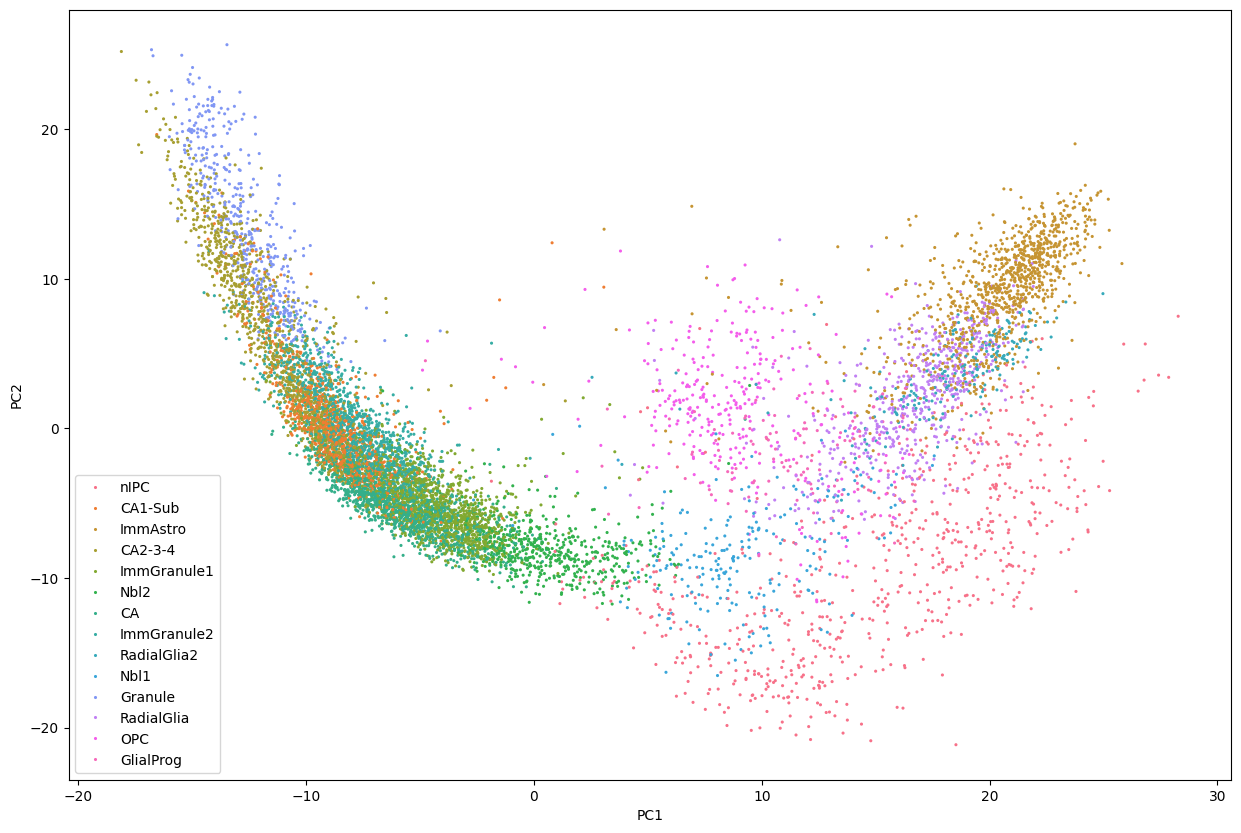

In [4]:
import seaborn as sns
#visualize PCA result
plt.figure(figsize=(15,10))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], linewidth = 0, s=5, hue=anno)
plt.xlabel('PC1')
plt.ylabel('PC2')

##  GraphDR: nonlinear dimensionality reduction that preserves linear interpretability

GraphDR is a nonlinear dimensionality reduction method that preserves the linear interpretability while improving on cell type representation quality. GraphDR combines the advantages of linear methods such as PCA and nonlinear methods such as t-SNE. Unlike t-SNE, GraphDR is also suitable for comparison across datasets.

In [56]:
X = pca_data

In [65]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph, eye, issparse

def graphdr_simple(X, lambda_,no_rotation = False,n_component = None):
    # Compute the k-nearest neighbors graph
    graph = kneighbors_graph(X, n_neighbors=105, mode='distance',metric="euclidean", include_self=False)
    graph = 0.5 * (graph + graph.T)
    # Compute the graph Laplacian
    graphL = csgraph.laplacian(graph)
    G = eye(X.shape[0]) + lambda_ * graphL
    if issparse(G):
        Ginv = np.linalg.inv(G.todense())
    else:
        Ginv = np.linalg.inv(G)
    if no_rotation:
        if n_component:
            try:
                X = X[:, :n_component]
            except:
                raise ValueError("n_component should be less than the number of features")
        Z = np.asarray(np.dot(X.T, Ginv).T)
    else:
        C = np.dot(np.dot(X.T, Ginv),X)
        _,W = np.linalg.eigh(C)
        W = np.array(W)
        W = W[:,::-1]
        if n_component:
            try:
                W = W[:, :n_component]
            except:
                raise ValueError("n_component should be less than the number of features")
            
        Z =  np.asarray(np.dot(np.dot(W.T, X.T), Ginv).T)
        
    return Z

Text(0, 0.5, 'GraphDR 2')

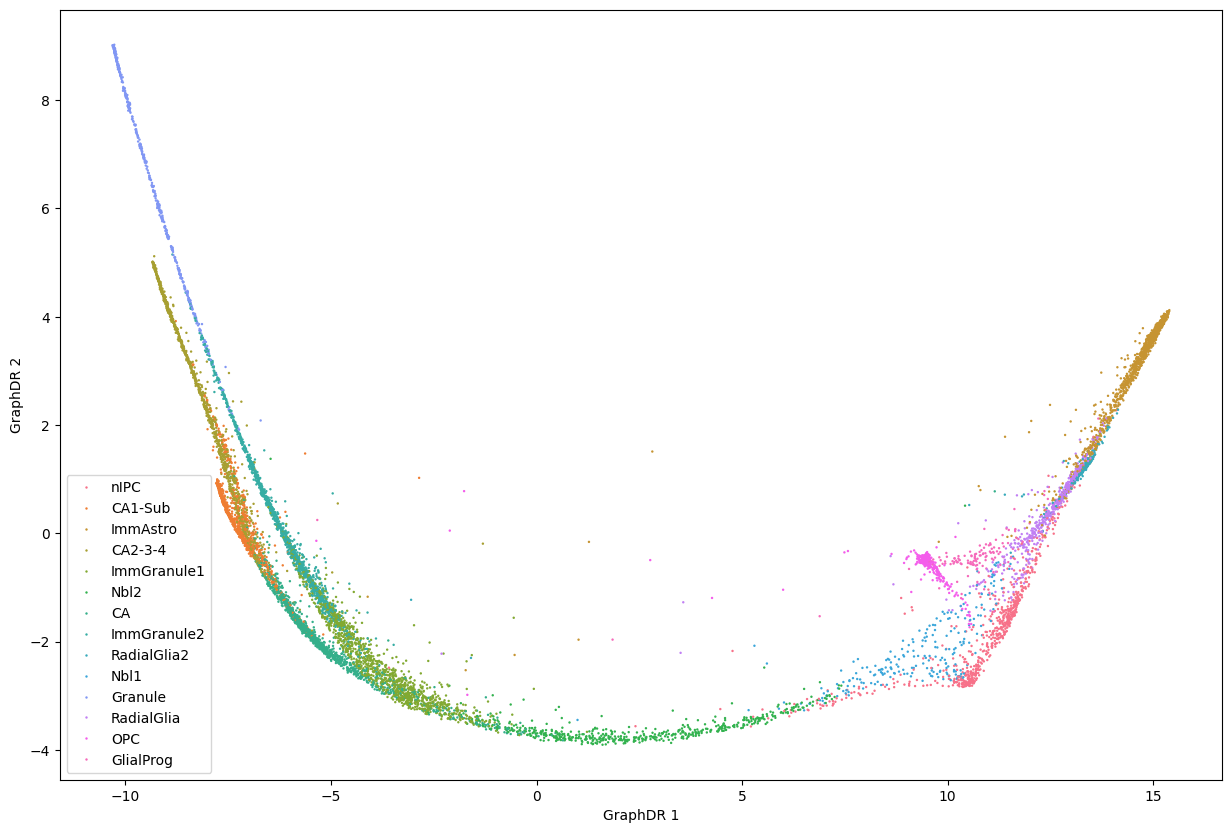

In [66]:
graphdr_data  = graphdr_simple(pca_data, lambda_=0.1, no_rotation=True)
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
sns.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')

Text(0, 0.5, 'GraphDR 2')

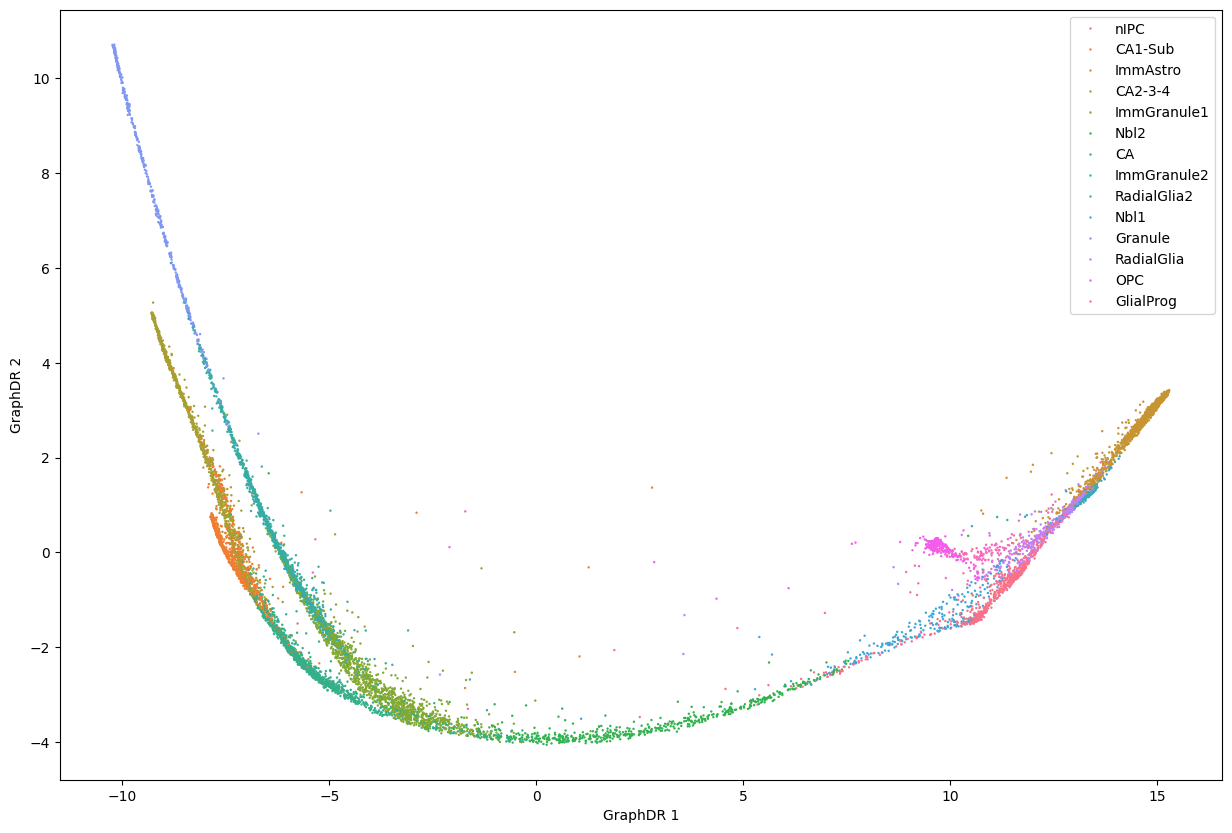

In [67]:
graphdr_data  = graphdr_simple(pca_data, lambda_=0.1, no_rotation=False)
#compare your graphdr output with this one, it should look similar (remember to adjust lambda_ and see its effect)

plt.figure(figsize=(15,10))
sns.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')

Text(0, 0.5, 'GraphDR 2')

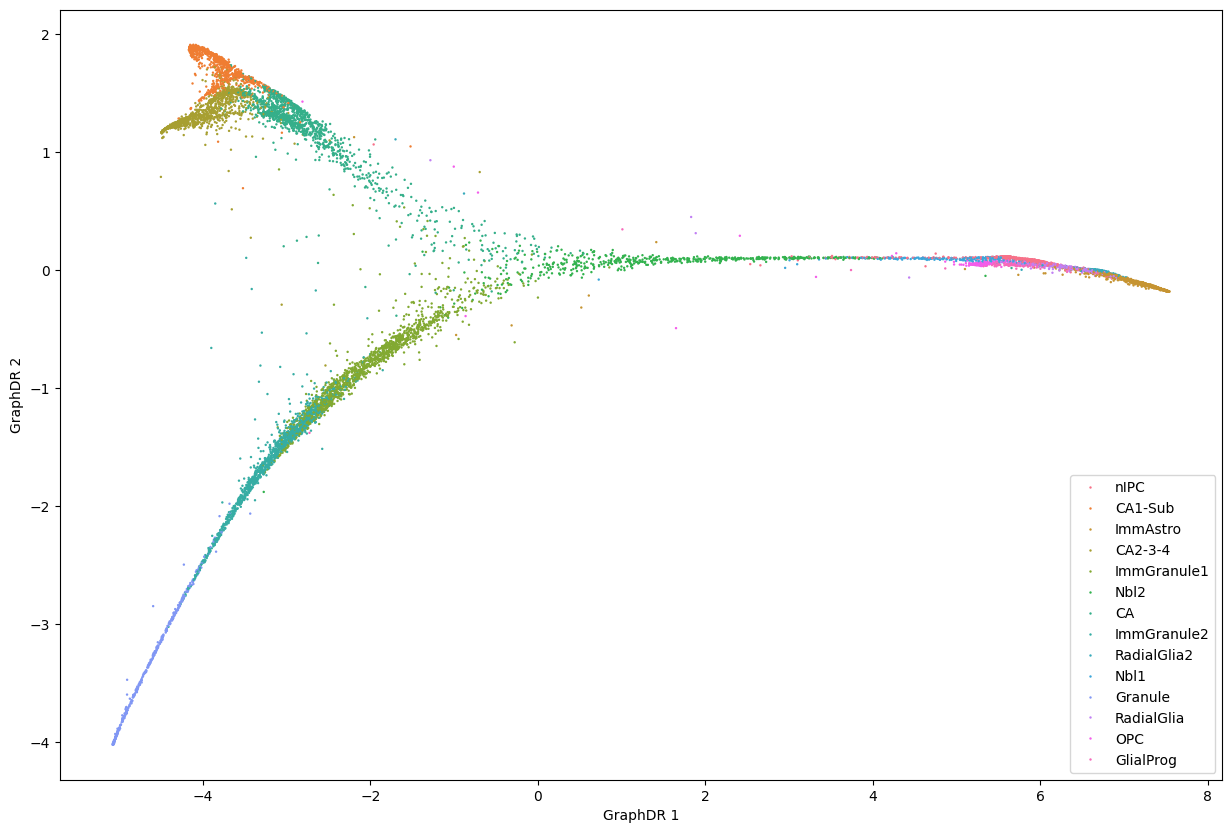

In [55]:
# change lambda will change the result significantly
graphdr_data  = graphdr_simple(pca_data, lambda_=0.5, no_rotation=False)
plt.figure(figsize=(15,10))
sns.scatterplot(x=graphdr_data[:,0], y=graphdr_data[:,1], linewidth = 0, s=3, hue=anno)
plt.xlabel('GraphDR 1')
plt.ylabel('GraphDR 2')